# Evaluación y selección de modelos

In [25]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

### Conjunto de datos (diagnóstico) de cáncer de mama

Para detalle de este conjunto de datos y más conjuntos de datos https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset 


In [27]:
dataset.head(10)

diagnosis  radius_mean  ...  symmetry_worst  fractal_dimension_worst
0          0        17.99  ...          0.4601                  0.11890
1          0        20.57  ...          0.2750                  0.08902
2          0        19.69  ...          0.3613                  0.08758
3          0        11.42  ...          0.6638                  0.17300
4          0        20.29  ...          0.2364                  0.07678
5          0        12.45  ...          0.3985                  0.12440
6          0        18.25  ...          0.3063                  0.08368
7          0        13.71  ...          0.3196                  0.11510
8          0        13.00  ...          0.4378                  0.10720
9          0        12.46  ...          0.4366                  0.20750

[10 rows x 31 columns]

In [ ]:
dataset.shape  #569 individuos y 30 variables predictoras

(569, 31)

**verificar que las clases no sean desbalanceadas**

Benigno: 357, Aproximadamente el 63% de los datos son de la clase 1 

Maligno: 212, Aproximadamente el 37% de los datos son de la clase 0


In [28]:
dataset.groupby('diagnosis')['diagnosis'].count()  #tenemos clases balanceadas

diagnosis
0    212
1    357
Name: diagnosis, dtype: int64

In [29]:
#transformación a la variable objetivo
dataset["diagnosis"] = [0 if int(s) == 1 else 1 for s in dataset["diagnosis"]]
dataset.groupby('diagnosis')['diagnosis'].count()  #tenemos clases balanceadas

diagnosis
0    357
1    212
Name: diagnosis, dtype: int64

Luego de la transformación así quedan las clases 


Benigno: 357, Aproximadamente el 63% de los datos son de la clase 0

Maligno: 212, Aproximadamente el 37% de los datos son de la clase 1

**Variable objetivo y variables predictoras**

In [30]:
y_target= dataset['diagnosis']
X_predictors = dataset.drop(columns=['diagnosis'])

**Muestra de entrenamiento y de prueba**

La función train_test_split, permite definir una muestra de validación y pruea a partir del porcentaje deseado para la muestra de prueba. Más información acá https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

545 muestras para el entrenamiento, de las cuales 285 son de la clase 0: Benigno y 260 de la clase 1: Maligno

114 muestras para prueba, de las cuales 72 son de la clase 0: Benigno y 42 de la clase 1: Maligno


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_predictors, y_target, test_size= 0.2, stratify=y_target, random_state= 1)

### Definición del modelo

En este caso aplicamos el algoritmo de clasificación de los k vecinos más cercanos, se puede leer documentación acá https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html 

También se define sobre cuáles hiperparametros se quiere realizar la optimización y los valores que se quieren probar, para construir la malla de hiperparametros y sobre esta realizar la búsqueda de hiperparametros óptimos 

In [33]:
model = KNeighborsClassifier()
n_neighbors= [5,10,15]
algorithm= ['auto', 'ball_tree', 'kd_tree', 'brute']
metric= ['euclidean', 'manhattan', 'minkowski']
grid = dict(n_neighbors= n_neighbors,algorithm= algorithm, metric= metric)

In [34]:
print(grid)  #diccionario donde la clase es el nombre del hiperparametro 
             #y el valor es una lista con los posibles valores que puede tomar el hiperparametro 

{'n_neighbors': [5, 10, 15], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'metric': ['euclidean', 'manhattan', 'minkowski']}


**Búsqueda de hiperparametros óptimos**

Buscamos hiperparametros tal que el modelo proporcione un buen desempeño, 

Para la búsqueda se usa validación cruzada ya que la muestra es muy pequeña y se corre el riesgo de sobreajuste.

La función RepeatedStratifiedKFold, permite realizar validación cruzada con repeticiones, lo que ayuda a tener una mejor generalización del comportamiento de los datos. Se puede encontrar más información acá https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html

La función GridSearchCV, ayuda a encontrar los hiperparametros óptimos a partir de un diccionario definido anteriormente y una métrica de selección definida. 

**Elegir la métrica objetivo**

- Recall (Exhaustividad): ¿qué porcentaje de los tumores malignos puede identificar el modelo?
$recall = \frac{TP}{TP + FN} =\frac{verdadero \space positivo}{verdadero  \space positivo \space + \space Falso \space negativo}$
- Accuracy (Exactitud): ¿Qué porcentaje de los diagnósticos ha predicho bien el modelo? 
$accuracy = \frac{verdadero \space positivo + \space verdadero \space negativo}{verdadero \space positivo \space + \space verdadero \space negativo \space + \space Falso \space positivo \space + \space Falso \space negativo}$
- Precision: ¿Qué porcentaje de los tumores predichos como malignos son realmente malignos?
$precision = \frac{verdadero \space positivo}{verdadero \space \space positivo + Falsos \space positivos}$
- f1_score: El valor F1 se utiliza para combinar las medidas de precision y recall en un sólo valor.
F1 se calcula haciendo la media armónica entre la precisión y la exhaustividad

Las métricas de desempeño permitidas se pueden encontrar acá https://scikit-learn.org/stable/modules/model_evaluation.html 


In [38]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)   # se usa cv para evitar sobreajuste porque la muestra es pequeña
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring= 'recall')
grid_result = grid_search.fit(X_train, y_train.values.ravel())


In [39]:
grid_result.cv_results_['params'] #36 modelos probados

[{'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 5},
 {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 10},
 {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 15},
 {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 5},
 {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 10},
 {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 15},
 {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 5},
 {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 10},
 {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 15},
 {'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 5},
 {'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 10},
 {'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 15},
 {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 5},
 {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 10},
 {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_ne

**Hiperparametros que proporcionan el mejor modelo entre los probados**

In [40]:
grid_result.best_params_

{'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 5}

In [41]:
grid_result.best_score_   #del total de individuos en la clase 1 el modelo logra identificar un 97%

0.8764705882352942

**¿Cómo se comporta el modelo con la muestra de prueba?**



In [42]:
y_pred= grid_search.predict(X_test)
y_prob = grid_search.predict_proba(X_test)
recall_score_ = recall_score(y_test,y_pred) 
accuracy_score_ = accuracy_score(y_test,y_pred)    
precision_score_ = precision_score(y_test,y_pred)
f1_score_ = f1_score(y_test,y_pred)
confusion_matrix_ = confusion_matrix(y_test,y_pred)

In [43]:
confusion_matrix_

array([[69,  3],
       [ 5, 37]])

In [44]:
recall_score_   #la métrica objetivo es muy similar con la muestra de prueba, el modelo se comporta bien con datos desconocidos

0.8809523809523809

In [45]:
metrics_best_model= {'accuracy_score': accuracy_score_,'precision_score': precision_score_,'f1_score': f1_score_, 'recall_score':recall_score_}
metrics_best_model

{'accuracy_score': 0.9298245614035088,
 'f1_score': 0.9024390243902439,
 'precision_score': 0.925,
 'recall_score': 0.8809523809523809}

**Matriz de confusión**

- Verdadero positivo: El valor real es positivo y  la prueba predijo tambien que era positivo. O bien una persona está enferma y la prueba así lo demuestra.
- Verdadero negativo: El valor real  es negativo y la prueba predijo tambien que el resultado era negativo. O bien la persona no está enferma y la prueba así lo  demuestra.
- Falso negativo: El valor real es positivo, y la prueba predijo  que el resultado es negativo. La persona está enferma, pero la prueba dice de manera incorrecta que no lo está. Esto es lo que en estadística se conoce como error tipo II
- Falso positivo: El valor real es negativo, y la prueba predijo  que el resultado es positivo. La persona no está enferma, pero la prueba nos dice de manera incorrecta que silo está. Esto es lo que en estadística se conoce como error tipo I

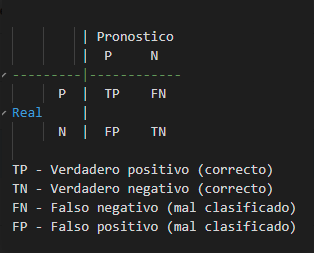

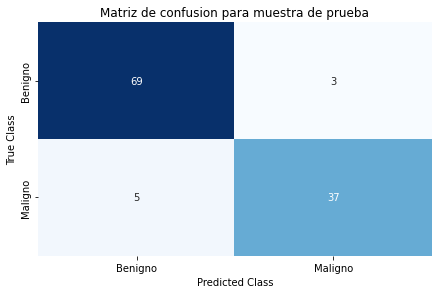

In [46]:
class_names = ['Benigno', 'Maligno']
dataframe = pd.DataFrame(confusion_matrix_, index=class_names, columns=class_names)
# crear mapa de calor dibujar mapa de calor
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues")
plt.title("Matriz de confusion para muestra de prueba"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

**Curva ROC**

La sensibilidad y la especificidad son dos valores que nos indican la capacidad de nuestro modelo para discriminar los casos positivos, de los negativos. La sensibilidad se representa como la fracción de verdaderos positivos, mientras que la especificidad, es la fracción de verdaderos negativos.

*Sensibilidad* o Razón de Verdaderos Positivos (VPR)

$VPR= \frac{VP}{(VP + FN)} = \frac{verdaderos \space positivos}{verdaderos \space positivos \space + \space falsos \space negativos}$

*Especificidad* o Razón de Verdaderos Negativos (SPC) 

$SPC = \frac{VN}{(FP+VN)} = \frac{verdaderos \space negativos}{verdaderos \space negativos \space + \space falsos \space positivos}$

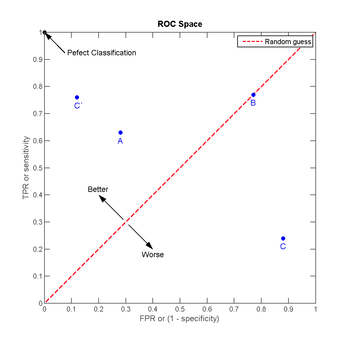

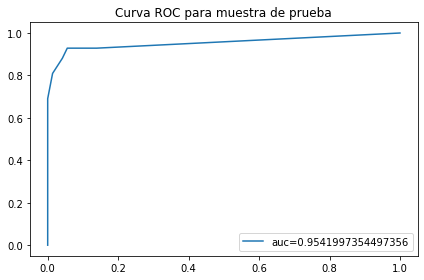

In [47]:
y_pred_proba = y_prob[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.title("Curva ROC para muestra de prueba"), plt.tight_layout()
plt.legend(loc=4)
plt.show()